<a href="https://colab.research.google.com/github/Rob-A-B/wildfire-hotspots/blob/Gold/src/queimadas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install dask dask[dataframe] pyarrow

In [2]:
!pip install cudf-cu12 dask-cudf-cu12 --extra-index-url=https://pypi.nvidia.com

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 119.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 MB 109.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-cuda-nvrtc-cu12
    Found existing installation: nvidia-cuda-nvrtc-cu12 12.6.77
    Uninstalling nvidia-cuda-nvrtc-cu12-12.6.77:
      Successfully uninstalled nvidia-cuda-nvrtc-cu12-12.6.77
  Attempting uninstall: nvidia-cuda-nvcc-cu12
    Found existing installation: nvidia-cuda-nvcc-cu12 12.5.82
    Uninstalling nvidia-cuda-nvcc-cu12-12.5.82:
      Successfully uninstalled nvidia-cuda-nvcc-cu12-12.5.82
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.9.0+cu126 requires nvidia-cuda-nvrtc-cu12==12.6.77; platform_system == "Linux", but you have nvidia-cuda-nvrtc-cu12 12.9.86 which is incompatible.

In [3]:
import os, datetime
from google.colab import files
import shutil, os, datetime
import os, glob, datetime
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import re
from google.colab import drive
import gc

import dask.dataframe as dd
import dask_cudf

In [4]:
hoje = datetime.date.today()
BASE   = "/content/projeto_pcb"
BRONZE_RAW = f"{BASE}/dados/bronze/raw"                   # onde guardamos os arquivos "brutos" por partição
BRONZE_CUR = f"{BASE}/dados/bronze/current"               # dataset consolidado (único arquivo)
os.makedirs(BRONZE_RAW, exist_ok=True)
os.makedirs(BRONZE_CUR, exist_ok=True)


DRIVE_CSV_PATH = "/content/drive/My Drive/8_periodo/Big Data/datasets"
os.makedirs(DRIVE_CSV_PATH, exist_ok=True)

# BRONZE

In [5]:
# 1) Descobrir todos os CSVs diretamente de um link ou ID de pasta compartilhada do Google Drive


shared_folder_link_or_id = 'https://drive.google.com/drive/folders/1hRgLe3t-zGgWqFH7ZAtW0m6XQdgOW3bh?usp=sharing'

download_dir = f"{DRIVE_CSV_PATH}/downloaded_csvs"
os.makedirs(download_dir, exist_ok=True)

print(f"📦 Attempting to download all files from shared Google Drive folder: {shared_folder_link_or_id}")

try:
    # Use gdown to download all files from the folder
    # The --folder flag indicates that the provided link/ID is for a folder
    # The -O flag specifies the output directory
    !gdown --no-cookies --no-check-certificate --folder "{shared_folder_link_or_id}" -O "{download_dir}"

    # After downloading, list the files in the download directory to process them
    arquivos_csv = [f for f in os.listdir(download_dir) if f.endswith(".csv") and os.path.isfile(os.path.join(download_dir, f))]
    print(f"📦 Downloaded {len(arquivos_csv)} CSVs to {download_dir}.\n")

except Exception as e:
    print(f"⚠️ Error during download: {e}")
    print("Please ensure gdown is installed (`!pip install gdown`), the folder link/ID is correct, and the folder is shared with 'Anyone with the link'.")
    arquivos_csv = [] # Ensure arquivos_csv is empty if download fails


# 2) Mover/copy to Bronze/raw partitioned and read into pandas DataFrames

for nome in arquivos_csv:
    caminho_src = os.path.join(download_dir, nome)

    # extrai AAAAMM do nome (ex.: focos_mensal_br_202311.csv)
    m = re.search(r'(\d{6})', nome)
    aaaamm = m.group(1) if m else f"{hoje.year}{hoje:%m}"
    ano, mes = aaaamm[:4], aaaamm[4:]

    # destino particionado (save as parquet in bronze raw)
    dest_dir = os.path.join(BRONZE_RAW, f"ano={ano}", f"mes={mes}")
    os.makedirs(dest_dir, exist_ok=True)
    nome_parquet = nome.replace(".csv", ".parquet")
    caminho_dst_parquet = os.path.join(dest_dir, nome_parquet)


    try:
        df_temp = pd.read_csv(caminho_src)
        df_temp["origem_arquivo"] = nome

        # salva como Parquet em bronze raw
        df_temp.to_parquet(caminho_dst_parquet, index=False)
        print(f"✅ Processado e salvo como Parquet: {nome}  ➜  {caminho_dst_parquet}")

        del df_temp # Free up memory
        gc.collect() # Run garbage collection

    except Exception as e:
        print(f"⚠️ Erro ao processar {caminho_src}: {e}")


# 3) Consolidate everything into a single Dask DataFrame (Bronze/current) by reading the Parquet files
if arquivos_csv:
    try:
        bronze_ddf = dask_cudf.read_parquet(os.path.join(BRONZE_RAW, "*/*/*.parquet"))

        # Convert 'ano' and 'mes' to Int64 as category dtype is not supported by parquet writer
        bronze_ddf["ano"] = bronze_ddf["ano"].astype("Int64")
        bronze_ddf["mes"] = bronze_ddf["mes"].astype("Int64")

        # Simple idempotence: remove exact duplicate rows
        bronze_ddf = bronze_ddf.drop_duplicates()

        print(f"\n🧱 Bronze consolidated: {len(bronze_ddf):,} linhas, {bronze_ddf.shape[1]} colunas")
        # For Dask, we use .head() to see the first few rows. This triggers computation.
        display(bronze_ddf.head())

        # 4) Salva consolidado (Parquet)
        out_parquet = os.path.join(BRONZE_CUR, "focos_bronze_consolidado.parquet")

        # To save as a single file, we repartition to 1 partition before saving
        bronze_ddf.repartition(npartitions=1).to_parquet(out_parquet)

        print(f"\n💾 Consolidado salvo em:\n - {out_parquet}")

    except Exception as e:
        print(f"⚠️ Erro ao consolidar ou salvar Bronze: {e}")
        # Handle the case where no parquet files were created
        if "Empty dataset" in str(e):
             print("No parquet files were created. Please check the download and processing steps.")

else:
    print("\nSkipping consolidation and saving Bronze as no CSV files were downloaded or processed.")

📦 Attempting to download all files from shared Google Drive folder: https://drive.google.com/drive/folders/1hRgLe3t-zGgWqFH7ZAtW0m6XQdgOW3bh?usp=sharing
Retrieving folder contents
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'drive.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
Retrieving folder 1ovB3SBy-8dycREpOpS6R8IvZf1M9Pucf silver
Processing file 1C0kSP8H1texrVhDk3phK3JpbFzobhOvn focos_mensal_br_202401.csv
Processing file 1A5R0ddrYc9h1mdC13BcZgionHE2DOBqG focos_mensal_br_202402.csv
Processing file 1FfQ3dMqa4P8nJsj6aduzmuRK7KTGIic9 focos_mensal_br_202403.csv
Processing file 1xPIWC_TV-mF3Va_N4x2DpXtzqmMv-Uxt focos_mensal_br_202404.csv
Processing file 1mqey7AzyRkuBped-T_Qx5hXl2EfE4WA0 focos_mensal_br_202405.csv
Processing file 1NMvoGVZM2txO2O_31i28oBEfABs2eT9A focos_mensal_b

,id,lat,lon,data_hora_gmt,satelite,municipio,estado,pais,municipio_id,estado_id,pais_id,numero_dias_sem_chuva,precipitacao,risco_fogo,bioma,frp,origem_arquivo,ano,mes
48609,ac6499d3-fc91-3468-abea-e6ca90796388,-5.35663,-47.22961,2024-01-10 16:43:00,NOAA-20,SENADOR LA ROCQUE,MARANHÃO,Brasil,2111763,21,33,2.0,0.20,0.01,Amazônia,56.5,focos_mensal_br_202401.csv,2024,1
48611,c88c5e63-1c57-31ea-a684-aac1167f4c5b,-5.28444,-47.37362,2024-01-10 16:43:00,NOAA-20,JOÃO LISBOA,MARANHÃO,Brasil,2105500,21,33,2.0,0.39,0.00,Cerrado,3.4,focos_mensal_br_202401.csv,2024,1
48614,14268722-9387-3ea7-85d4-4701a4592029,-19.84694,-55.34079,2024-01-10 16:43:00,NOAA-20,CORGUINHO,MATO GROSSO DO SUL,Brasil,5003108,50,33,6.0,0.00,0.89,Cerrado,11.6,focos_mensal_br_202401.csv,2024,1
48620,ce4a1fed-5c45-37a2-91bc-8a8d70ca25d7,-19.52765,-56.66718,2024-01-10 16:43:00,NOAA-20,CORUMBÁ,MATO GROSSO DO SUL,Brasil,5003207,50,33,7.0,0.00,0.35,Pantanal,4.7,focos_mensal_br_202401.csv,2024,1
48630,90b2ac2a-1a77-391e-8054-b9849618ba0d,-19.51257,-56.75309,2024-01-10 16:43:00,NOAA-20,CORUMBÁ,MATO GROSSO DO SUL,Brasil,5003207,50,33,7.0,0.00,0.29,Pantanal,7.6,focos_mensal_br_202401.csv,2024,1



💾 Consolidado salvo em:
 - /content/projeto_pcb/dados/bronze/current/focos_bronze_consolidado.parquet


In [6]:
bronze_ddf.info()

<class 'dask_cudf._expr.collection.DataFrame'>
Columns: 19 entries, id to mes
dtypes: object(8), float64(5), int64(6)

In [7]:
bronze_ddf.isna().sum().compute()

id                            0
lat                           0
lon                           0
data_hora_gmt                 0
satelite                      0
municipio                     0
estado                        0
pais                          0
municipio_id                  0
estado_id                     0
pais_id                       0
numero_dias_sem_chuva    125852
precipitacao             125852
risco_fogo               125852
bioma                         4
frp                      374354
origem_arquivo                0
ano                           0
mes                           0
dtype: int64

In [8]:
df_temp = None
del df_temp
gc.collect()

84

# SILVER

In [9]:
hoje = datetime.date.today()
BASE = "/content/projeto_pcb"
BRONZE = "/content/projeto_pcb/dados/bronze/current"
SILVER = "/content/projeto_pcb/dados/silver"
os.makedirs(SILVER, exist_ok=True)

In [10]:

paths = sorted(glob.glob(os.path.join(BRONZE, "*.parquet")))
assert paths, "Nenhum arquivo Parquet encontrado em bronze."

bronze_ddf = dd.read_parquet(paths[0]) # Assuming the consolidated file is the first one

esperadas = {"data_hora_gmt","satelite","municipio","estado"}
# Check for missing columns (Dask DataFrames have columns attribute)
faltando = esperadas - set(bronze_ddf.columns)
assert not faltando, f"Faltam colunas no dataset: {faltando}"

bronze_ddf["data_hora_gmt"] = bronze_ddf["data_hora_gmt"].astype('datetime64[ns, UTC]')

for c in ["satelite","municipio","estado"]:
      bronze_ddf[c] = bronze_ddf[c].astype(str).str.strip()

bronze_ddf = bronze_ddf.dropna(subset=["data_hora_gmt"])

# Identify and replace -999 with NaN in numeric columns
numeric_cols = bronze_ddf.select_dtypes(include=np.number).columns
# Use Dask's assign with a dictionary comprehension for replacement
replace_dict = {col: bronze_ddf[col].replace(-999, np.nan) for col in numeric_cols}
bronze_ddf = bronze_ddf.assign(**replace_dict)


# Calculate and print proportion of NaNs per column using Dask
nan_proportion_per_column = bronze_ddf.isnull().sum().compute() / len(bronze_ddf) * 100
print("\nProporção de NaN por coluna (%):")
print(nan_proportion_per_column)

# Calculate and print proportion of rows with NaN using Dask
rows_with_nan = bronze_ddf.isnull().any(axis=1).sum().compute()
proportion_rows_with_nan = rows_with_nan / len(bronze_ddf) * 100
print(f"\nProporção de linhas com NaN no total do dataset (%): {proportion_rows_with_nan:.2f}%")

bronze_ddf = bronze_ddf.dropna()

bronze_ddf = bronze_ddf.drop(columns=['id', 'lat','lon','municipio_id','estado_id','pais_id','pais','origem_arquivo', 'ano', 'mes'])


# Extract date components using Dask's .dt accessor
bronze_ddf["ano"] = bronze_ddf["data_hora_gmt"].dt.year.astype("Int64")
bronze_ddf["mes"] = bronze_ddf["data_hora_gmt"].dt.month.astype("Int64")
bronze_ddf["dia"] = bronze_ddf["data_hora_gmt"].dt.day.astype("Int64")

# carga que prof pediu
bronze_ddf["dt_carga"] = datetime.date.today().isoformat()

# Salva silver as Parquet
SILVER_FILE =  f"focos_silver_{datetime.date.today():%Y%m%d}.parquet"
silver_parquet = os.path.join(SILVER,SILVER_FILE)
os.makedirs(SILVER, exist_ok=True)

# Save as a single parquet file
bronze_ddf.repartition(npartitions=1).to_parquet(silver_parquet)


print("Silver salvo:", silver_parquet, "| linhas:", len(bronze_ddf))

display(bronze_ddf.head())


Proporção de NaN por coluna (%):
id                       0.000000
lat                      0.000000
lon                      0.000000
data_hora_gmt            0.000000
satelite                 0.000000
municipio                0.000000
estado                   0.000000
pais                     0.000000
municipio_id             0.000000
estado_id                0.000000
pais_id                  0.000000
numero_dias_sem_chuva    1.916553
precipitacao             1.180835
risco_fogo               2.209782
bioma                    0.000038
frp                      3.512460
origem_arquivo           0.000000
ano                      0.000000
mes                      0.000000
dtype: float64

Proporção de linhas com NaN no total do dataset (%): 6.23%
Silver salvo: /content/projeto_pcb/dados/silver/focos_silver_20251201.parquet | linhas: 9993721


,data_hora_gmt,satelite,municipio,estado,numero_dias_sem_chuva,precipitacao,risco_fogo,bioma,frp,ano,mes,dia,dt_carga
11003,2024-01-05 02:30:00+00:00,TERRA_M-M,IRACEMA,RORAIMA,12.0,0.0,0.64,Amazônia,14.3,2024,1,5,2025-12-01
17798,2024-01-06 16:17:00+00:00,NOAA-20,SANTA CRUZ DA BAIXA VERDE,PERNAMBUCO,5.0,0.0,0.58,Caatinga,4.4,2024,1,6,2025-12-01
17803,2024-01-06 16:17:00+00:00,NOAA-20,TRACUNHAÉM,PERNAMBUCO,5.0,0.0,1.0,Mata Atlântica,6.0,2024,1,6,2025-12-01
13867,2024-01-05 16:41:00+00:00,NOAA-20,BOA VISTA,RORAIMA,10.0,0.0,1.0,Amazônia,21.6,2024,1,5,2025-12-01
17804,2024-01-06 16:17:00+00:00,NOAA-20,BUENOS AIRES,PERNAMBUCO,5.0,0.0,1.0,Mata Atlântica,4.6,2024,1,6,2025-12-01


In [11]:
bronze_ddf.isna().sum()

Dask Series Structure:
npartitions=1
ano         int64
satelite      ...
Dask Name: sum, 57 expressions
Expr=(IsNa(frame=Assign(frame=Assign(frame=Assign(frame=Assign(frame=Drop(frame=DropnaFrame(frame=Assign(frame=DropnaFrame(frame=Assign(frame=Assign(frame=Assign(frame=Assign(frame=ReadParquetFSSpec(79abe27))))), subset=['data_hora_gmt']))), columns=['id', 'lat', 'lon', 'municipio_id', 'estado_id', 'pais_id', 'pais', 'origem_arquivo', 'ano', 'mes']))))))).sum()

In [12]:
bronze_ddf = None
del bronze_ddf
gc.collect()

318

# GOLD

In [13]:
GOLD = "/content/projeto_pcb/dados/gold"
os.makedirs(GOLD, exist_ok=True)

In [14]:
# ============================
# CAMADA GOLD - QUEIMADAS (AJUSTADA 2)
# ============================

import os
import glob
import dask.dataframe as dd

BASE = "/content/projeto_pcb"
SILVER = os.path.join(BASE, "dados", "silver")
GOLD = os.path.join(BASE, "dados", "gold")

os.makedirs(GOLD, exist_ok=True)

def carregar_silver_mais_recente():
    """
    Lê o arquivo mais recente da camada Silver (focos_silver_YYYYMMDD.parquet)
    e devolve um Dask DataFrame.
    """
    pattern = os.path.join(SILVER, "focos_silver_*.parquet")
    paths = sorted(glob.glob(pattern))
    assert paths, f"Nenhum arquivo Silver encontrado em {SILVER}"
    silver_path = paths[-1]  # pega o mais recente pela ordenação
    print(f"📁 Usando Silver: {silver_path}")
    ddf = dd.read_parquet(silver_path)

    # Garantir tipos básicos
    if "ano" in ddf.columns:
        ddf["ano"] = ddf["ano"].astype("int64")
    if "mes" in ddf.columns:
        ddf["mes"] = ddf["mes"].astype("int64")

    return ddf

silver_ddf = carregar_silver_mais_recente()

# -----------------------------
# GOLD 1: Focos por Estado/Mês
# Grão: (ano, mes, estado)
# -----------------------------

def construir_gold_estado_mensal(ddf):
    obrigatorias = ["ano", "mes", "estado", "municipio"]
    for col in obrigatorias:
        assert col in ddf.columns, f"Coluna obrigatória ausente em Silver: {col}"

    gb = ddf.groupby(["ano", "mes", "estado"])

    # 1) número de municípios distintos
    municipios_nunique = gb["municipio"].nunique().rename("qtd_municipios_com_foco")

    # 2) colunas numéricas para média
    num_cols = [c for c in ["frp", "numero_dias_sem_chuva", "precipitacao", "risco_fogo"]
                if c in ddf.columns]

    if num_cols:
        medias = gb[num_cols].mean()
    else:
        medias = None

    # Junta tudo
    if medias is not None:
        grouped = dd.concat([municipios_nunique, medias], axis=1)
    else:
        grouped = municipios_nunique.to_frame()

    grouped = grouped.reset_index()

    # renomeia colunas numéricas
    rename_map = {}
    if "frp" in num_cols:
        rename_map["frp"] = "frp_medio"
    if "numero_dias_sem_chuva" in num_cols:
        rename_map["numero_dias_sem_chuva"] = "dias_sem_chuva_medio"
    if "precipitacao" in num_cols:
        rename_map["precipitacao"] = "precipitacao_media"
    if "risco_fogo" in num_cols:
        rename_map["risco_fogo"] = "risco_fogo_medio"

    grouped = grouped.rename(columns=rename_map)

    out_path = os.path.join(GOLD, "focos_gold_estado_mensal.parquet")
    grouped = grouped.repartition(npartitions=1)
    grouped.to_parquet(out_path, write_index=False)

    print("✅ Gold (estado/mês) salvo em:", out_path)
    # .head() aqui já computa e vira pandas
    print(grouped.head())
    return grouped

# -----------------------------
# GOLD 2: Focos por Bioma/Mês
# Grão: (ano, mes, bioma)
# -----------------------------

def construir_gold_bioma_mensal(ddf):
    obrigatorias = ["ano", "mes", "bioma"]
    for col in obrigatorias:
        assert col in ddf.columns, f"Coluna obrigatória ausente em Silver: {col}"

    # Cria coluna dummy para contar focos
    ddf = ddf.assign(_foco=1)

    gb = ddf.groupby(["ano", "mes", "bioma"])

    # 1) quantidade de focos
    qtd_focos = gb["_foco"].sum().rename("qtd_focos")

    # 2) colunas numéricas para média
    num_cols = [c for c in ["frp", "numero_dias_sem_chuva", "precipitacao", "risco_fogo"]
                if c in ddf.columns]

    if num_cols:
        medias = gb[num_cols].mean()
    else:
        medias = None

    if medias is not None:
        grouped = dd.concat([qtd_focos, medias], axis=1)
    else:
        grouped = qtd_focos.to_frame()

    grouped = grouped.reset_index()

    rename_map = {}
    if "frp" in num_cols:
        rename_map["frp"] = "frp_medio"
    if "numero_dias_sem_chuva" in num_cols:
        rename_map["numero_dias_sem_chuva"] = "dias_sem_chuva_medio"
    if "precipitacao" in num_cols:
        rename_map["precipitacao"] = "precipitacao_media"
    if "risco_fogo" in num_cols:
        rename_map["risco_fogo"] = "risco_fogo_medio"

    grouped = grouped.rename(columns=rename_map)

    out_path = os.path.join(GOLD, "focos_gold_bioma_mensal.parquet")
    grouped = grouped.repartition(npartitions=1)
    grouped.to_parquet(out_path, write_index=False)

    print("✅ Gold (bioma/mês) salvo em:", out_path)
    print(grouped.head())
    return grouped

# -----------------------------
# EXECUTAR AS CONSTRUÇÕES GOLD
# -----------------------------

gold_estado = construir_gold_estado_mensal(silver_ddf)
gold_bioma  = construir_gold_bioma_mensal(silver_ddf)


📁 Usando Silver: /content/projeto_pcb/dados/silver/focos_silver_20251201.parquet
✅ Gold (estado/mês) salvo em: /content/projeto_pcb/dados/gold/focos_gold_estado_mensal.parquet
    ano  mes      estado  qtd_municipios_com_foco  dias_sem_chuva_medio  \
0  2024    1     RORAIMA                       15             12.764921   
1  2024    1  PERNAMBUCO                      165              5.015289   
2  2024    1       CEARÁ                      173              3.833359   
3  2024    1        PARÁ                      123              2.012493   
4  2024    1    MARANHÃO                      192              1.587229   

   precipitacao_media  risco_fogo_medio  frp_medio  
0            0.059969          0.835986  39.907021  
1            1.095917          0.682616  13.269083  
2            0.587365          0.565875  20.802093  
3            1.880643          0.162674  11.204675  
4            3.508868          0.046437  14.338526  
✅ Gold (bioma/mês) salvo em: /content/projeto_pcb/dados

##Predição e Gráficos


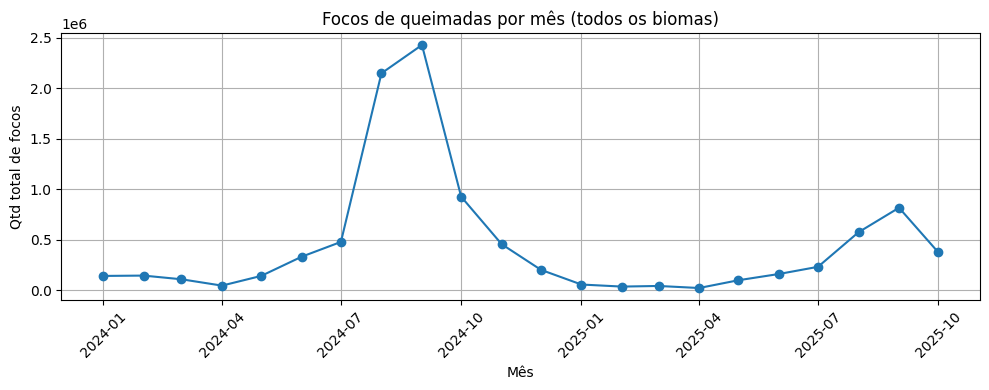

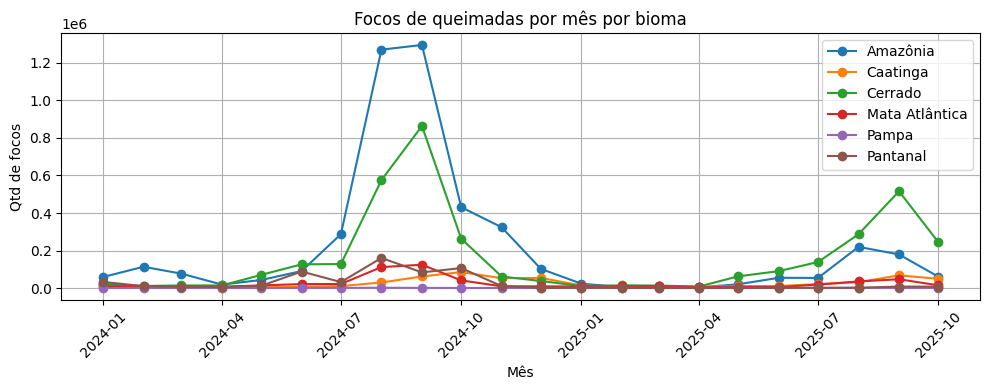


Modelo: RandomForest — Bioma Amazônia
MAE  = 416,057.67
RMSE = 464,951.15

Último mês observado: 2025-10
Focos observados: 60627
Previsão próximo mês: 619039


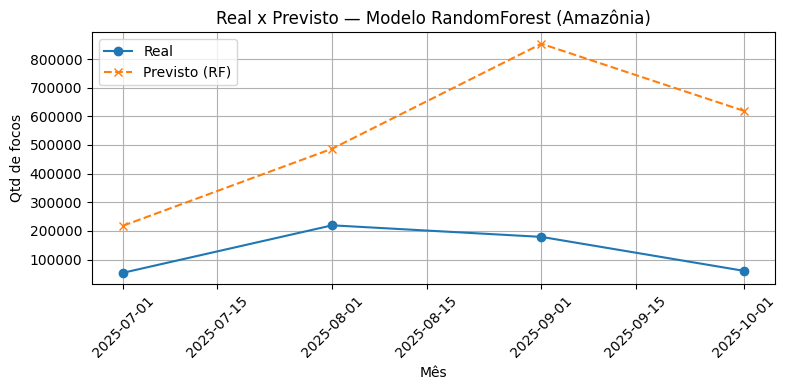

In [15]:
# ===============================================
# PREDIÇÃO APRIMORADA + GRÁFICOS GERAIS
# ===============================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

BASE = "/content/projeto_pcb"
GOLD = os.path.join(BASE, "dados", "gold")

# -----------------------------------------
# 1. Carrega Gold (bioma/mês)
# -----------------------------------------
gold_path = os.path.join(GOLD, "focos_gold_bioma_mensal.parquet")
df = pd.read_parquet(gold_path)

df["data_ref"] = pd.to_datetime(
    dict(year=df["ano"], month=df["mes"], day=1)
)

df = df.sort_values("data_ref")

# ===========================================================
# GRAFICO GERAL 1 — Focos totais por mês (todos os biomas)
# ===========================================================
df_total = df.groupby("data_ref")["qtd_focos"].sum().reset_index()

plt.figure(figsize=(10,4))
plt.plot(df_total["data_ref"], df_total["qtd_focos"], marker="o")
plt.title("Focos de queimadas por mês (todos os biomas)")
plt.xlabel("Mês")
plt.ylabel("Qtd total de focos")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ===========================================================
# GRAFICO GERAL 2 — Focos por bioma por mês (linhas separadas)
# ===========================================================
plt.figure(figsize=(10,4))
for bioma in df["bioma"].unique():
    subset = df[df["bioma"] == bioma]
    plt.plot(subset["data_ref"], subset["qtd_focos"], marker="o", label=bioma)

plt.title("Focos de queimadas por mês por bioma")
plt.xlabel("Mês")
plt.ylabel("Qtd de focos")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# ===========================================================
# 2. PREDIÇÃO APRIMORADA — RANDOM FOREST
# ===========================================================

BIOMA = "Amazônia"
serie = df[df["bioma"] == BIOMA].copy()

serie = serie.sort_values("data_ref").reset_index(drop=True)

# -----------------------------
# 3. Criar features para ML
# -----------------------------
serie["lag_1"] = serie["qtd_focos"].shift(1)
serie["lag_2"] = serie["qtd_focos"].shift(2)
serie["lag_3"] = serie["qtd_focos"].shift(3)

serie["media_3m"] = serie["qtd_focos"].rolling(3).mean().shift(1)
serie["media_6m"] = serie["qtd_focos"].rolling(6).mean().shift(1)

# Feature de sazonalidade
serie["mes_num"] = serie["mes"]

# remove linhas com NaN
base_ml = serie.dropna()

# -----------------------------
# 4. Treino/Teste respeitando tempo
# -----------------------------
n = len(base_ml)
n_teste = min(4, max(1, n // 4))

treino = base_ml.iloc[:-n_teste]
teste  = base_ml.iloc[-n_teste:]

X_train = treino[["lag_1","lag_2","lag_3","media_3m","media_6m","mes_num"]]
y_train = treino["qtd_focos"]

X_test = teste[["lag_1","lag_2","lag_3","media_3m","media_6m","mes_num"]]
y_test = teste["qtd_focos"]

# -----------------------------
# 5. Modelo RandomForest
# -----------------------------
rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=8,
    random_state=42
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))

print(f"\nModelo: RandomForest — Bioma {BIOMA}")
print(f"MAE  = {mae:,.2f}")
print(f"RMSE = {rmse:,.2f}")

# -----------------------------
# 6. Predição do próximo mês
# -----------------------------
ultimo = base_ml.iloc[[-1]]
X_next = ultimo[["lag_1","lag_2","lag_3","media_3m","media_6m","mes_num"]]

pred_next = rf.predict(X_next)[0]

print(f"\nÚltimo mês observado: {ultimo['data_ref'].dt.strftime('%Y-%m').iloc[0]}")
print("Focos observados:", int(ultimo["qtd_focos"].iloc[0]))
print("Previsão próximo mês:", int(pred_next))

# -----------------------------
# 7. GRAFICO REAL X PREVISTO
# -----------------------------
plt.figure(figsize=(8,4))
plt.plot(teste["data_ref"], y_test.values, marker="o", label="Real")
plt.plot(teste["data_ref"], y_pred, marker="x", linestyle="--", label="Previsto (RF)")
plt.title(f"Real x Previsto — Modelo RandomForest ({BIOMA})")
plt.xlabel("Mês")
plt.ylabel("Qtd de focos")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


### Regressão Linear


MAE = 71062.0
RMSE = 74642.26276471706


/tmp/ipython-input-518217986.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["t"] = np.arange(len(train))
/tmp/ipython-input-518217986.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["t"]  = np.arange(len(train), len(train) + len(test))


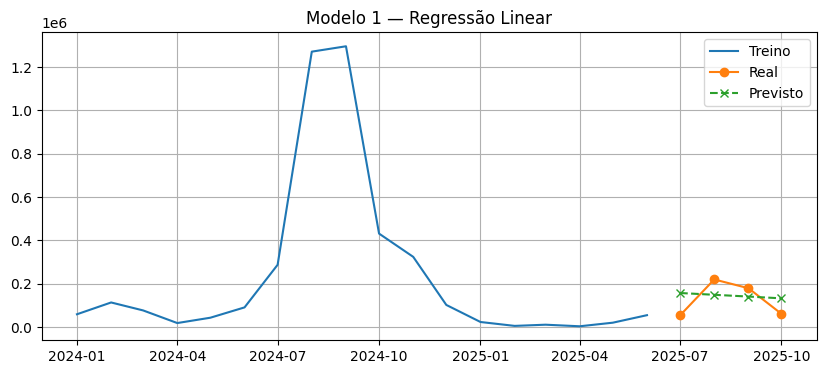

In [16]:
# ===========================================================
# MODELO 1 — Regressão Linear (baseline fraco)
# ===========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

BASE = "/content/projeto_pcb"
GOLD = f"{BASE}/dados/gold/focos_gold_bioma_mensal.parquet"

df = pd.read_parquet(GOLD)
df["data_ref"] = pd.to_datetime(dict(year=df["ano"], month=df["mes"], day=1))
df = df.sort_values("data_ref")

BIOMA = "Amazônia"
serie = df[df["bioma"] == BIOMA][["data_ref", "qtd_focos"]].set_index("data_ref").asfreq("MS")

n_test = 4
train = serie.iloc[:-n_test]
test  = serie.iloc[-n_test:]

# FEATURES
train["t"] = np.arange(len(train))
test["t"]  = np.arange(len(train), len(train) + len(test))

X_train = train[["t"]]
y_train = train["qtd_focos"]
X_test  = test[["t"]]
y_test  = test["qtd_focos"]

lin = LinearRegression().fit(X_train, y_train)
pred = lin.predict(X_test)

mae = mean_absolute_error(y_test, pred)
rmse = sqrt(mean_squared_error(y_test, pred))

print("MAE =", mae)
print("RMSE =", rmse)

plt.figure(figsize=(10,4))
plt.plot(train.index, train["qtd_focos"], label="Treino")
plt.plot(test.index,  test["qtd_focos"],  marker="o", label="Real")
plt.plot(test.index,  pred,              marker="x", linestyle="--", label="Previsto")
plt.title("Modelo 1 — Regressão Linear")
plt.grid(True)
plt.legend()
plt.show()


### Random Forest Regressor

/tmp/ipython-input-3990311615.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["lag1"] = train["qtd_focos"].shift(1)
/tmp/ipython-input-3990311615.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["lag2"] = train["qtd_focos"].shift(2)
/tmp/ipython-input-3990311615.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

MAE = 225898.3075
RMSE = 324090.7674430558


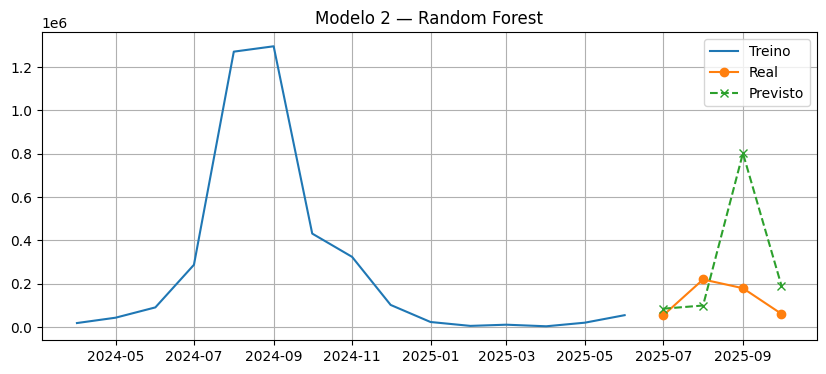

In [17]:
# ===========================================================
# MODELO 2 — Random Forest Regressor
# ===========================================================

from sklearn.ensemble import RandomForestRegressor

serie = df[df["bioma"] == BIOMA][["data_ref", "qtd_focos"]].set_index("data_ref").asfreq("MS")

n_test = 4
train = serie.iloc[:-n_test]
test  = serie.iloc[-n_test:]

train["lag1"] = train["qtd_focos"].shift(1)
train["lag2"] = train["qtd_focos"].shift(2)
train["lag3"] = train["qtd_focos"].shift(3)
test["lag1"]  = serie["qtd_focos"].shift(1).iloc[-n_test:]
test["lag2"]  = serie["qtd_focos"].shift(2).iloc[-n_test:]
test["lag3"]  = serie["qtd_focos"].shift(3).iloc[-n_test:]

train = train.dropna()
test  = test.dropna()

X_train = train[["lag1","lag2","lag3"]]
y_train = train["qtd_focos"]
X_test  = test[["lag1","lag2","lag3"]]
y_test  = test["qtd_focos"]

rf = RandomForestRegressor(n_estimators=400, max_depth=8, random_state=42)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, pred)
rmse = sqrt(mean_squared_error(y_test, pred))
print("MAE =", mae)
print("RMSE =", rmse)

plt.figure(figsize=(10,4))
plt.plot(train.index, train["qtd_focos"], label="Treino")
plt.plot(test.index,  test["qtd_focos"],  marker="o", label="Real")
plt.plot(test.index,  pred,              marker="x", linestyle="--", label="Previsto")
plt.title("Modelo 2 — Random Forest")
plt.grid(True)
plt.legend()
plt.show()


### Simple Exponential Smoothing

MAE = 74057.00025837868
RMSE = 103344.57370657424


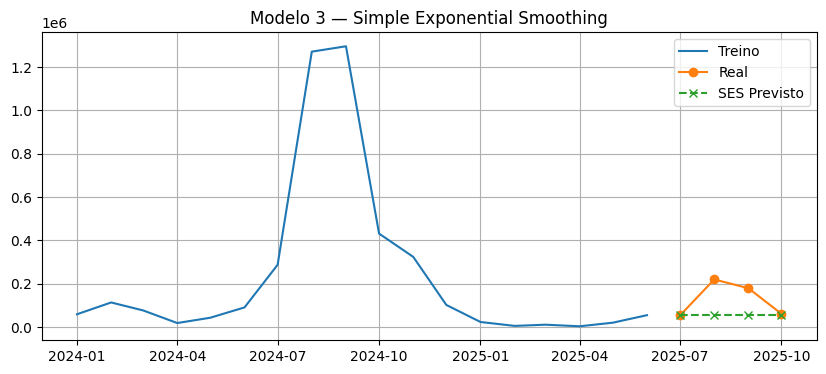

In [18]:
# ===========================================================
# MODELO 3 — Simple Exponential Smoothing (SES)
# ===========================================================

from statsmodels.tsa.holtwinters import SimpleExpSmoothing

serie = df[df["bioma"] == BIOMA][["data_ref", "qtd_focos"]].set_index("data_ref").asfreq("MS")

n_test = 4
train = serie.iloc[:-n_test]
test  = serie.iloc[-n_test:]

ses = SimpleExpSmoothing(train).fit()
pred = ses.forecast(n_test)

mae = mean_absolute_error(test, pred)
rmse = sqrt(mean_squared_error(test, pred))
print("MAE =", mae)
print("RMSE =", rmse)

plt.figure(figsize=(10,4))
plt.plot(train.index, train.values, label="Treino")
plt.plot(test.index,  test.values, marker="o", label="Real")
plt.plot(pred.index,  pred.values, marker="x", linestyle="--", label="SES Previsto")
plt.title("Modelo 3 — Simple Exponential Smoothing")
plt.grid(True)
plt.legend()
plt.show()


### Sazonal Naïve

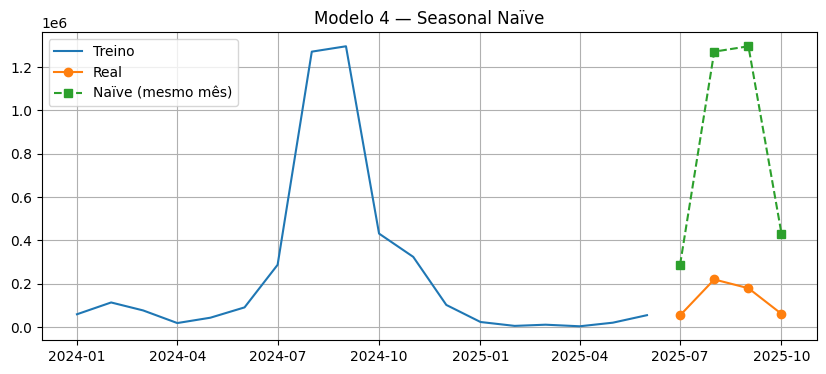

In [19]:
# ===========================================================
# MODELO 4 — Sazonal Naïve (valor do mês do ano passado)
# ===========================================================

serie = df[df["bioma"] == BIOMA][["data_ref", "qtd_focos"]].set_index("data_ref").asfreq("MS")

n_test = 4
train = serie.iloc[:-n_test]
test  = serie.iloc[-n_test:]

naive = serie.shift(12).iloc[-n_test:]

plt.figure(figsize=(10,4))
plt.plot(train.index, train.values, label="Treino")
plt.plot(test.index,  test.values, marker="o", label="Real")
plt.plot(naive.index, naive.values, marker="s", linestyle="--", label="Naïve (mesmo mês)")
plt.title("Modelo 4 — Seasonal Naïve")
plt.grid(True)
plt.legend()
plt.show()


### Seasonal Ratio Forecasting

Fator proporcional médio = qtd_focos    0.179273
dtype: float64
MAE = 20116.942080981484
RMSE = 28191.849688141443


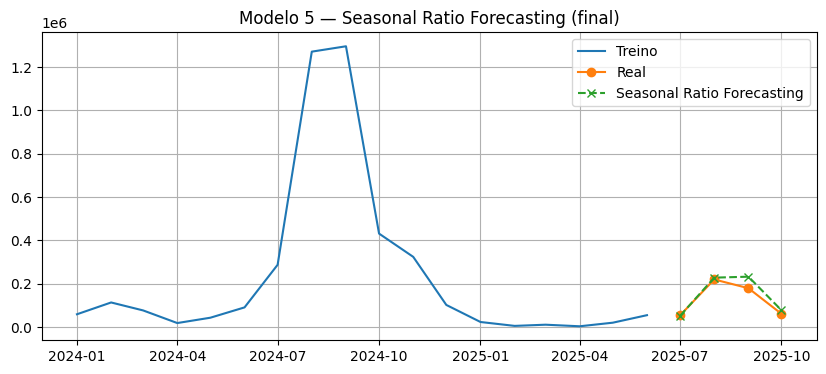

In [20]:
# ===========================================================
# MODELO 5 — Seasonal Ratio Forecasting (FINAL)
# ===========================================================

serie = df[df["bioma"] == BIOMA][["data_ref","qtd_focos"]].set_index("data_ref").asfreq("MS")

n_test = 4
train = serie.iloc[:-n_test]
test  = serie.iloc[-n_test:]

shifted = serie.shift(12)

# Razões “ano atual / ano anterior”
ratios = (serie / shifted).dropna()
fator_medio = ratios.median()

print("Fator proporcional médio =", fator_medio)

# Previsão proporcional
prop = shifted * fator_medio
prop = prop.iloc[-n_test:].reindex(test.index)

mae = mean_absolute_error(test, prop)
rmse = sqrt(mean_squared_error(test, prop))
print("MAE =", mae)
print("RMSE =", rmse)

plt.figure(figsize=(10,4))
plt.plot(train.index, train.values, label="Treino")
plt.plot(test.index,  test.values, marker="o", label="Real")
plt.plot(prop.index,  prop.values, marker="x", linestyle="--", label="Seasonal Ratio Forecasting")
plt.title("Modelo 5 — Seasonal Ratio Forecasting (final)")
plt.grid(True)
plt.legend()
plt.show()


In [21]:
# ============================================================
# DASHBOARD: KPIs + PREVISÃO (Seasonal Ratio Forecasting)
# ============================================================

import os
import numpy as np
import pandas as pd
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ------------------------------------------------------------
# 1) Caminhos base
# ------------------------------------------------------------
BASE = "/content/projeto_pcb"
GOLD_DIR = os.path.join(BASE, "dados", "gold")
DASH_DIR = os.path.join(BASE, "dados", "dashboard")

os.makedirs(DASH_DIR, exist_ok=True)

# ------------------------------------------------------------
# 2) Carrega Gold (estado e bioma)
# ------------------------------------------------------------
path_gold_estado = os.path.join(GOLD_DIR, "focos_gold_estado_mensal.parquet")
path_gold_bioma  = os.path.join(GOLD_DIR, "focos_gold_bioma_mensal.parquet")

df_estado = pd.read_parquet(path_gold_estado)
df_bioma  = pd.read_parquet(path_gold_bioma)

# Cria coluna data_ref = 1º dia de cada mês (facilita no BI)
for df in (df_estado, df_bioma):
    df["data_ref"] = pd.to_datetime(dict(year=df["ano"], month=df["mes"], day=1))

# ------------------------------------------------------------
# 3) KPIs para dashboards
# ------------------------------------------------------------

# 3.1 KPI geral por mês (todos os biomas somados)
kpi_mes = (
    df_bioma
    .groupby("data_ref")
    .agg(
        qtd_focos_total=("qtd_focos", "sum"),
        frp_medio_geral=("frp_medio", "mean"),
        risco_fogo_medio_geral=("risco_fogo_medio", "mean")
    )
    .reset_index()
)

# 3.2 KPI por bioma (por mês)
kpi_bioma = df_bioma[
    ["data_ref", "ano", "mes", "bioma", "qtd_focos",
     "dias_sem_chuva_medio", "precipitacao_media",
     "risco_fogo_medio", "frp_medio"]
].copy()

# 3.3 KPI por estado (por mês)
kpi_estado = df_estado[
    ["data_ref", "ano", "mes", "estado",
     "qtd_municipios_com_foco",
     "dias_sem_chuva_medio", "precipitacao_media",
     "risco_fogo_medio", "frp_medio"]
].copy()

# Salva CSVs de KPI
csv_kpi_mes    = os.path.join(DASH_DIR, "kpi_mensal_geral.csv")
csv_kpi_bioma  = os.path.join(DASH_DIR, "kpi_mensal_bioma.csv")
csv_kpi_estado = os.path.join(DASH_DIR, "kpi_mensal_estado.csv")

kpi_mes.to_csv(csv_kpi_mes, index=False)
kpi_bioma.to_csv(csv_kpi_bioma, index=False)
kpi_estado.to_csv(csv_kpi_estado, index=False)

print("✅ KPIs salvos:")
print("   Geral  :", csv_kpi_mes)
print("   Bioma  :", csv_kpi_bioma)
print("   Estado :", csv_kpi_estado)

# ------------------------------------------------------------
# 4) Seasonal Ratio Forecasting para um bioma (Amazônia)
#     Histórico + previsão + intervalo de confiança
# ------------------------------------------------------------

BIOMA_ALVO = "Amazônia"
seasonal_period = 12
n_test = 4
h_futuro = 3

# Série mensal do bioma alvo
serie = (
    df_bioma[df_bioma["bioma"] == BIOMA_ALVO]
      .set_index("data_ref")["qtd_focos"]
      .asfreq("MS")
      .sort_index()
)

print("\n📈 Série do bioma", BIOMA_ALVO, "- tamanho:", len(serie))

# Separa treino e teste
train = serie.iloc[:-n_test]
test  = serie.iloc[-n_test:]

# Série deslocada 12 meses
shifted = serie.shift(seasonal_period)

# Razões ano atual / ano anterior
ratios = (serie / shifted).dropna()
fator_medio = ratios.median()

print("Fator médio proporcional (ano atual / ano anterior) =", fator_medio)

# Previsão proporcional para todos os meses em que existe ano anterior
y_hat_all = shifted * fator_medio

# Resíduos onde há real e previsto -> para estimar sigma e CI
residuos = (serie - y_hat_all).dropna()
sigma = residuos.std()
ci_width = 1.96 * sigma  # intervalo de confiança 95%

# ---------------- Histórico (treino + teste) ----------------
df_hist = pd.DataFrame({
    "data_ref": serie.index,
    "bioma": BIOMA_ALVO,
    "qtd_focos_real": serie.values,
    "qtd_focos_previsto": y_hat_all.values,
})

df_hist["ci_inferior"] = df_hist["qtd_focos_previsto"] - ci_width
df_hist["ci_superior"] = df_hist["qtd_focos_previsto"] + ci_width

df_hist["tipo_periodo"] = "treino"
df_hist.loc[df_hist["data_ref"].isin(test.index), "tipo_periodo"] = "teste"

# ---------------- Previsões futuras ----------------
future_idx = pd.date_range(
    start=serie.index[-1] + pd.offsets.MonthBegin(),
    periods=h_futuro,
    freq="MS"
)

future_vals = []
for dt in future_idx:
    dt_passado = dt - pd.DateOffset(years=1)
    if dt_passado in serie.index:
        future_vals.append(serie.loc[dt_passado] * fator_medio)
    else:
        future_vals.append(np.nan)

df_future = pd.DataFrame({
    "data_ref": future_idx,
    "bioma": BIOMA_ALVO,
    "qtd_focos_real": np.nan,
    "qtd_focos_previsto": future_vals,
})
df_future["ci_inferior"] = df_future["qtd_focos_previsto"] - ci_width
df_future["ci_superior"] = df_future["qtd_focos_previsto"] + ci_width
df_future["tipo_periodo"] = "previsao"

# Junta histórico + futuro
df_pred = pd.concat([df_hist, df_future], ignore_index=True)

# Métricas de erro no período de teste (só pra você comentar no relatório)
mask_teste = df_pred["tipo_periodo"] == "teste"
mae = mean_absolute_error(
    df_pred.loc[mask_teste, "qtd_focos_real"],
    df_pred.loc[mask_teste, "qtd_focos_previsto"]
)
rmse = sqrt(mean_squared_error(
    df_pred.loc[mask_teste, "qtd_focos_real"],
    df_pred.loc[mask_teste, "qtd_focos_previsto"]
))

print("\n📊 Erros no período de teste (bioma", BIOMA_ALVO, "):")
print("   MAE  =", round(mae, 2))
print("   RMSE =", round(rmse, 2))

# Salva CSV de previsão
csv_forecast = os.path.join(
    DASH_DIR,
    f"previsao_{BIOMA_ALVO.lower().replace(' ', '_')}_seasonal_ratio.csv"
)
df_pred.to_csv(csv_forecast, index=False)

print("\n✅ Dataset de previsão salvo em:")
print("  ", csv_forecast)

print("\nPrévia do dataset de previsão:")
display(df_pred.tail(8))


✅ KPIs salvos:
   Geral  : /content/projeto_pcb/dados/dashboard/kpi_mensal_geral.csv
   Bioma  : /content/projeto_pcb/dados/dashboard/kpi_mensal_bioma.csv
   Estado : /content/projeto_pcb/dados/dashboard/kpi_mensal_estado.csv

📈 Série do bioma Amazônia - tamanho: 22
Fator médio proporcional (ano atual / ano anterior) = 0.17927303887586818

📊 Erros no período de teste (bioma Amazônia ):
   MAE  = 20116.94
   RMSE = 28191.85

✅ Dataset de previsão salvo em:
   /content/projeto_pcb/dados/dashboard/previsao_amazônia_seasonal_ratio.csv

Prévia do dataset de previsão:


,data_ref,bioma,qtd_focos_real,qtd_focos_previsto,ci_inferior,ci_superior,tipo_periodo
17,2025-06-01,Amazônia,54637.0,16239.806773,-30444.774006,62924.387552,treino
18,2025-07-01,Amazônia,53775.0,51499.586605,4815.005826,98184.167384,teste
19,2025-08-01,Amazônia,219506.0,227859.797145,181175.216366,274544.377924,teste
20,2025-09-01,Amazônia,179144.0,232303.975779,185619.395000,278988.556558,teste
21,2025-10-01,Amazônia,60627.0,77305.582005,30621.001226,123990.162784,teste
22,2025-11-01,Amazônia,NaN,58048.251442,11363.670663,104732.832221,previsao
23,2025-12-01,Amazônia,NaN,18270.970303,-28413.610476,64955.551082,previsao
24,2026-01-01,Amazônia,NaN,4147.661027,-42536.919752,50832.241806,previsao


### Análise profunda de modelo (Random Forest)


DataFrame Bioma/Mensal carregado (tamanho: 132).

Dados separados para treino e teste.

🚀 Iniciando treinamento dos modelos de Regressão...
✅ Treinamento concluído. Analisando métricas...

## 📊 Comparação de Desempenho dos Modelos (Target: risco_fogo_medio)
                                  RMSE    MAE  R2 Score
Random Forest Regressor         0.1242 0.0963    0.7994
Gradient Boosting Regressor     0.1470 0.1114    0.7188
Ridge Regression (Regularizado) 0.1830 0.1333    0.5646
Linear Regression               0.1896 0.1371    0.5325

🏆 O melhor modelo é: Random Forest Regressor


/tmp/ipython-input-4291273979.py:147: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_plot_df.index, y='R2 Score', data=metrics_plot_df, palette="viridis")
/tmp/ipython-input-4291273979.py:158: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_plot_df.index, y='RMSE', data=metrics_plot_df, palette="magma")


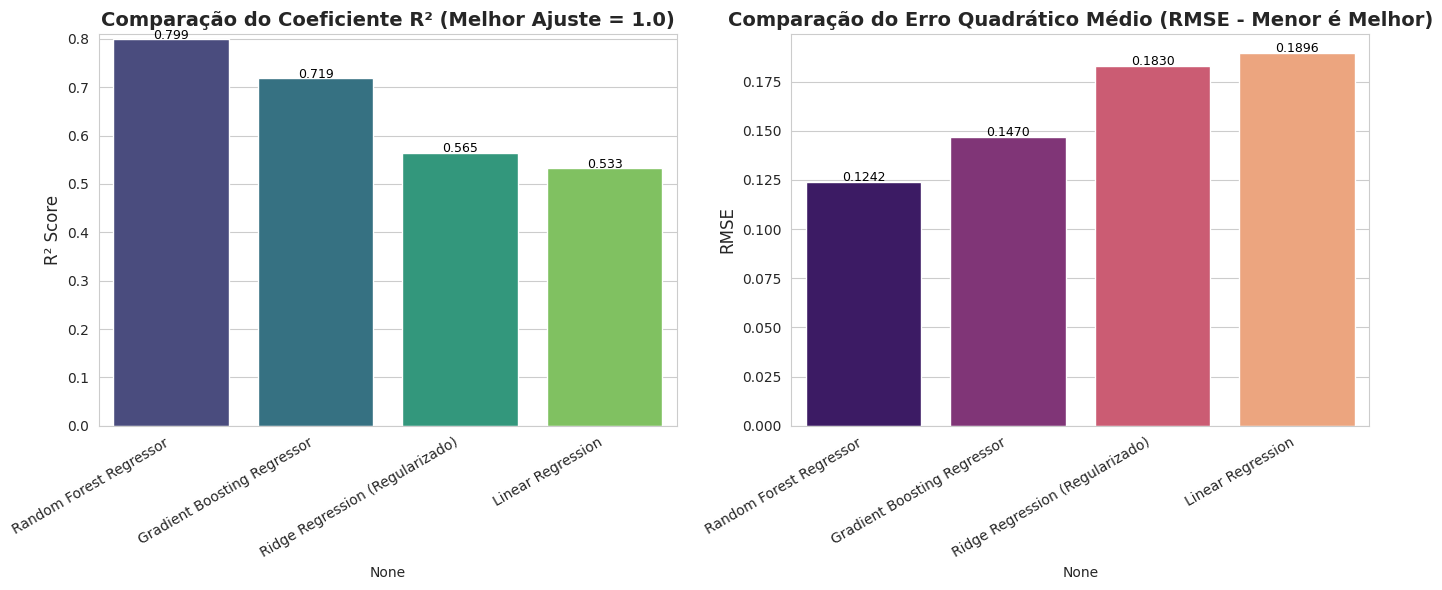


## 🔥 Importância das Variáveis (Modelo: Random Forest Regressor)
Métrica: Qual variável mais contribui para a previsão do Risco de Fogo Médio.
dias_sem_chuva_medio   0.6891
qtd_focos              0.0938
frp_medio              0.0874
precipitacao_media     0.0736
bioma_Amazônia         0.0293
bioma_Caatinga         0.0064
bioma_Pantanal         0.0062
bioma_Pampa            0.0052
bioma_Mata Atlântica   0.0049
bioma_Cerrado          0.0041


/tmp/ipython-input-4291273979.py:200: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances_top.values, y=importances_top.index, palette="mako")


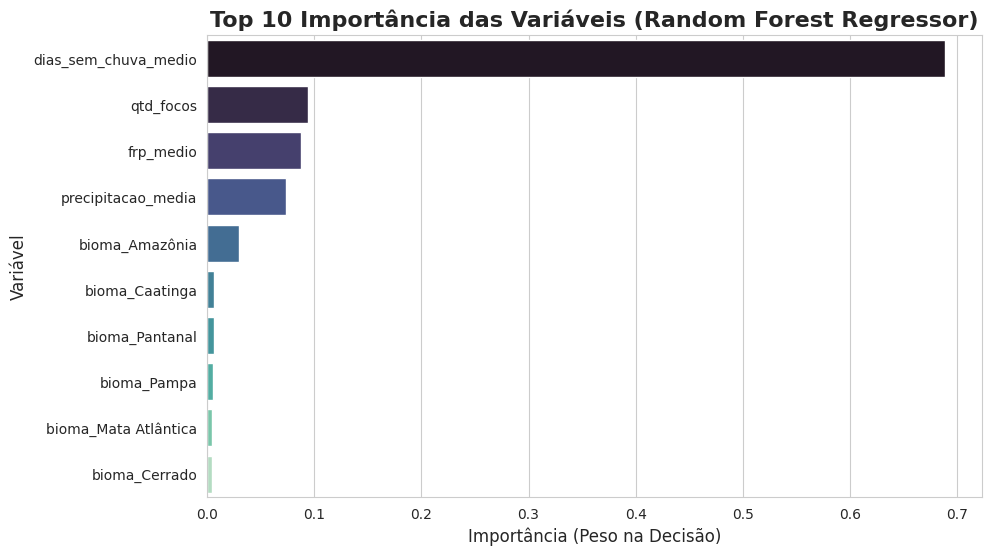


## 📈 Visualização: Predição vs. Real (Random Forest Regressor)


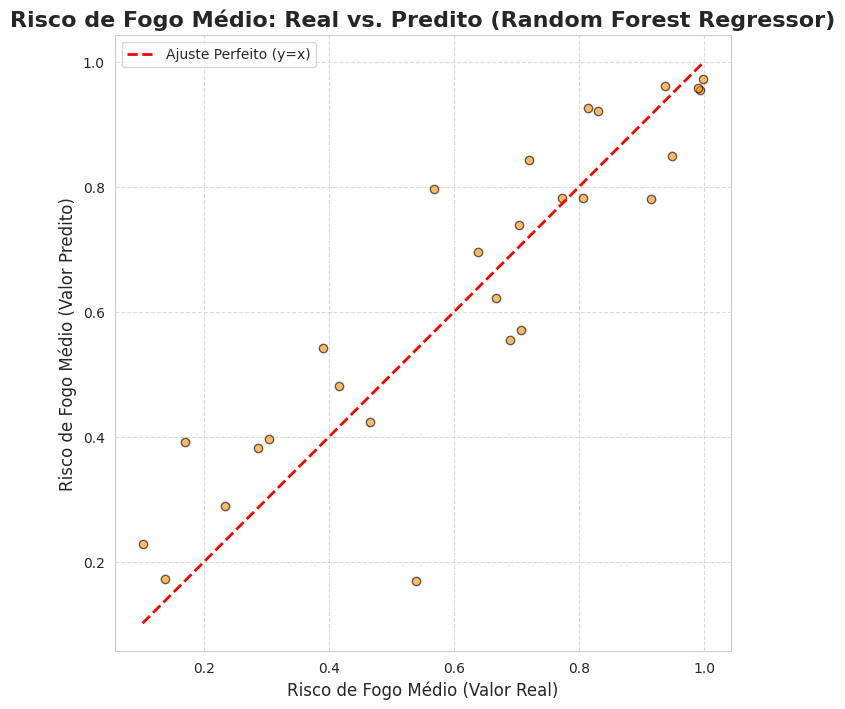

In [22]:
import os
import glob
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt # Adicionado para visualização
import seaborn as sns # Adicionado para visualização

# ============================
# CONFIGURAÇÃO E CARREGAMENTO DE DADOS GOLD
# ============================

# Assumindo que os dados GOLD foram salvos no diretório abaixo.
BASE = "/content/projeto_pcb"
GOLD = os.path.join(BASE, "dados", "gold")

def load_gold_data(filename_pattern):
    """Carrega o arquivo Parquet GOLD mais recente que corresponde ao padrão."""
    # Como o nome do arquivo GOLD é fixo agora, usamos o nome exato.
    path = os.path.join(GOLD, filename_pattern)
    return pd.read_parquet(path)

# Usaremos a agregação Bioma/Mensal
try:
    df_bioma = load_gold_data("focos_gold_bioma_mensal.parquet")
    print(f"\nDataFrame Bioma/Mensal carregado (tamanho: {len(df_bioma)}).")
except Exception as e:
    print(f"Erro ao carregar dados GOLD: {e}")
    exit()

# ============================
# PREPARAÇÃO DE DADOS (FEATURE ENGINEERING E PRÉ-PROCESSAMENTO)
# ============================

# Target (Variável Alvo)
TARGET = 'risco_fogo_medio'
y = df_bioma[TARGET]

# Features (Variáveis Preditivas)
NUMERIC_FEATURES = ['qtd_focos', 'frp_medio', 'dias_sem_chuva_medio', 'precipitacao_media']
CATEGORICAL_FEATURES = ['bioma']

# Usaremos 'ano' e 'mes' como features numéricas para capturar tendências temporais,
# mas são tratados como cíclicos. Para simplicidade, usamos como numéricas.
X = df_bioma[NUMERIC_FEATURES + CATEGORICAL_FEATURES]

# Separação Treino/Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nDados separados para treino e teste.")

# Pré-processamento com ColumnTransformer:
# 1. Padroniza (StandardScaler) as features numéricas.
# 2. Codifica (OneHotEncoder) as features categóricas (bioma).

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, NUMERIC_FEATURES),
        ('cat', categorical_transformer, CATEGORICAL_FEATURES)
    ],
    remainder='passthrough'
)

# ============================
# TREINAMENTO E AVALIAÇÃO DE MÚLTIPLOS MODELOS
# ============================

# Modelos de Regressão para prever a variável contínua (Risco de Fogo Médio)
MODELS = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression (Regularizado)": Ridge(alpha=1.0, random_state=42),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42, n_jobs=-1),
    "Gradient Boosting Regressor": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
}

results = {}
best_model_name = ""
best_r2 = -np.inf

print("\n🚀 Iniciando treinamento dos modelos de Regressão...")

for name, model in MODELS.items():
    # Cria o Pipeline completo: Pré-processador + Modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', model)])

    # Treinamento
    pipeline.fit(X_train, y_train)

    # Previsão
    y_pred = pipeline.predict(X_test)

    # Avaliação de Métricas
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse) # Root Mean Squared Error (Erro na unidade do alvo)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        "RMSE": rmse,
        "MAE": mae,
        "R2 Score": r2,
        "model_object": pipeline
    }

    if r2 > best_r2:
        best_r2 = r2
        best_model_name = name

print("✅ Treinamento concluído. Analisando métricas...")

# ============================
# ANÁLISE DE PROFUNDIDADE (MÉTRICAS E IMPORTÂNCIA DE FEATURES)
# ============================

# 1. Comparação de Métricas
metrics_df = pd.DataFrame({k: {m: v for m, v in val.items() if m != 'model_object'} for k, val in results.items()}).T
print("\n" + "="*80)
print(f"## 📊 Comparação de Desempenho dos Modelos (Target: {TARGET})")
print("="*80)
print(metrics_df.sort_values(by="R2 Score", ascending=False).to_string(float_format="%.4f"))

print(f"\n🏆 O melhor modelo é: {best_model_name}")

# 1.5. Visualização das Métricas
metrics_plot_df = metrics_df[['R2 Score', 'RMSE']].sort_values(by="R2 Score", ascending=False)

sns.set_style("whitegrid")
plt.figure(figsize=(14, 6))

# Plot 1: R2 Score
plt.subplot(1, 2, 1)
sns.barplot(x=metrics_plot_df.index, y='R2 Score', data=metrics_plot_df, palette="viridis")
plt.title('Comparação do Coeficiente R² (Melhor Ajuste = 1.0)', fontsize=14, fontweight='bold')
plt.ylabel('R² Score', fontsize=12)
plt.xticks(rotation=30, ha='right')
plt.ylim(0, metrics_plot_df['R2 Score'].max() + 0.01)
for index, row in metrics_plot_df.iterrows():
    plt.text(index, row['R2 Score'] + 0.001, f"{row['R2 Score']:.3f}", color='black', ha="center", fontsize=9)


# Plot 2: RMSE
plt.subplot(1, 2, 2)
sns.barplot(x=metrics_plot_df.index, y='RMSE', data=metrics_plot_df, palette="magma")
plt.title('Comparação do Erro Quadrático Médio (RMSE - Menor é Melhor)', fontsize=14, fontweight='bold')
plt.ylabel('RMSE', fontsize=12)
plt.xticks(rotation=30, ha='right')
for index, row in metrics_plot_df.iterrows():
    plt.text(index, row['RMSE'] + 0.0005, f"{row['RMSE']:.4f}", color='black', ha="center", fontsize=9)

plt.tight_layout()
plt.show()


# 2. Análise de Importância de Variáveis (Feature Importance)
best_pipeline = results[best_model_name]['model_object']
best_regressor = best_pipeline['regressor']

# Função para extrair nomes de features pós-codificação
def get_feature_names(preprocessor, numeric_features, categorical_features):
    # Nomes numéricos
    feature_names = numeric_features[:]

    # Nomes categóricos codificados
    ohe = preprocessor.named_transformers_['cat']['onehot']
    cat_names = ohe.get_feature_names_out(categorical_features)
    feature_names.extend(cat_names)

    return feature_names

feature_names = get_feature_names(best_pipeline['preprocessor'], NUMERIC_FEATURES, CATEGORICAL_FEATURES)

# Apenas modelos baseados em árvore possuem 'feature_importances_'
if hasattr(best_regressor, 'feature_importances_'):
    importances = pd.Series(best_regressor.feature_importances_, index=feature_names)
    print("\n" + "="*80)
    print(f"## 🔥 Importância das Variáveis (Modelo: {best_model_name})")
    print("="*80)
    print("Métrica: Qual variável mais contribui para a previsão do Risco de Fogo Médio.")
    print(importances.nlargest(10).sort_values(ascending=False).to_string(float_format="%.4f"))

    # 2.5. Visualização da Importância das Features
    importances_top = importances.nlargest(10)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances_top.values, y=importances_top.index, palette="mako")
    plt.title(f'Top 10 Importância das Variáveis ({best_model_name})', fontsize=16, fontweight='bold')
    plt.xlabel('Importância (Peso na Decisão)', fontsize=12)
    plt.ylabel('Variável', fontsize=12)
    plt.show()

# 3. Visualização de Previsão vs. Real (Melhor Modelo)
print("\n" + "="*80)
print(f"## 📈 Visualização: Predição vs. Real ({best_model_name})")
print("="*80)

# Fazer a previsão no conjunto de teste usando o melhor modelo
y_pred_best = best_pipeline.predict(X_test)

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_best, alpha=0.6, color='darkorange', edgecolors='black')
# Linha de ajuste perfeito (y=x)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ajuste Perfeito (y=x)')
plt.title(f'Risco de Fogo Médio: Real vs. Predito ({best_model_name})', fontsize=16, fontweight='bold')
plt.xlabel('Risco de Fogo Médio (Valor Real)', fontsize=12)
plt.ylabel('Risco de Fogo Médio (Valor Predito)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.gca().set_aspect('equal', adjustable='box') # Garantir escala 1:1
plt.show()

# 4. Análise do Coeficiente (Para Regressão Linear)
if isinstance(best_regressor, LinearRegression) or isinstance(best_regressor, Ridge):
    print("\n" + "="*80)
    print("## ⚖️ Coeficientes do Modelo Linear")
    print("="*80)
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coeficiente': best_regressor.coef_
    })
    coef_df['Impacto'] = np.abs(coef_df['Coeficiente'])
    print(coef_df.sort_values('Impacto', ascending=False).to_string(index=False, float_format="%.4f"))